In [1]:
import pandas as pd
from pathlib import Path
import sys
sys.path.append('..')

## Make df of straws from file

In [2]:
# organized by their panel; includes batch, position number
#straw_list_file = Path("straws_on_panels.csv")
straw_list_file = Path("2022-04-07_straws_on_panels.csv")
straw_list_file = Path("2022-04-15_straws_on_panels.csv") #include paper pull grade
assert straw_list_file.is_file()
straws_df = pd.read_csv(straw_list_file, sep=",")
#straws_list = np.loadtxt(straw_list_file, delimiter=",", dtype=int, skiprows=1, usecols=range(1))
straws_df.columns = straws_df.columns.str.replace(" ", "")
straws_df = straws_df.rename(columns={"id": "straw"})
straws_df

,number,position_number,straw,batch,paper_pull_grade
0,215,0,25367,120517B3,A
1,215,1,25463,113017B3,A
2,215,2,25439,120117B3,B
3,215,3,25406,113017B4,B
4,215,4,25366,120517B3,A
5,215,5,25462,113017B3,B
6,215,6,25438,120117B3,B
7,215,7,25393,113017B4,A
8,215,8,25365,120517B3,A
9,215,9,25461,113017B3,A


## Refit function

In [3]:
import guis.straw.leak.straw_leak_utilities as util
from guis.straw.leak.least_square_linear import get_fit

In [4]:
# Skip points at beginning and end
def truncate(container, nstart, nend):
    return container[max(nstart - 1, 0) : len(container) - nend]

In [5]:
class NotEnoughData(Exception):
    pass

In [6]:
# We won't use the skip-start/endpoints functionality, but leaving it around just in case.
def refit(raw_data_file_fullpath, n_skips_start = 0, n_skips_end = 0):
    leak_rate = 0
    leak_rate_err = 0

    slope = []
    slope_err = []
    intercept = []
    intercept_err = []

    # Get data from raw data file
    timestamp, ppm, ppm_err = util.get_data_from_file(raw_data_file_fullpath)

    timestamp = truncate(timestamp, n_skips_start, n_skips_end)
    ppm = truncate(ppm, n_skips_start, n_skips_end)
    ppm_err = truncate(ppm_err, n_skips_start, n_skips_end)

    # not enough data
    if not timestamp:
        raise NotEnoughData
        
    # Calculate slopes, leak rates
    raw_data_filename = raw_data_file_fullpath.name
    try:
        chamber = int(raw_data_filename[15:17])
    except:
        chamber = int(raw_data_filename[15:16])
    slope, slope_err, intercept, intrcept_err = get_fit(timestamp, ppm, ppm_err)

    leak_rate = util.calculate_leak_rate(slope, util.get_chamber_volume(chamber))

    leak_rate_err = util.calculate_leak_rate_err(
        leak_rate,
        slope,
        slope_err,
        util.get_chamber_volume(chamber),
        util.get_chamber_volume_err(chamber),
    )

    # pass, fail, or unknown
    leak_status = util.evaluate_leak_rate(len(ppm), leak_rate, leak_rate_err, timestamp[-1])

    #print("\n  Status leak rate after refit:", leak_status)

    return leak_rate, leak_rate_err, leak_status

## Raw data location

In [7]:
from guis.common.getresources import GetProjectPaths
# straw leak raw data location
indir = GetProjectPaths()["strawleakdata"] / "raw_data"
print(indir)

/Users/Ben/Home/Working/mu2e-tracker-factory/data/StrawLeak/raw_data


## DF of {straw, raw data file, fit value, fit error, fit status}
#### this step takes the longest (~minutes)

In [8]:
import importlib
importlib.reload(util)
# one row for each file – many rows for one straw are allowed.
file_list = []
for raw_data_file in indir.glob("*.txt"):
    straw = str(raw_data_file.name)[2:7]
    
    #if straw != "23839":
    #    continue
        
    try:
        straw = int(straw)
    except ValueError:
        print("BAD FILE (FILENAME)", raw_data_file.name)
        continue

    try:
        leak_rate, leak_rate_err, leak_status = refit(raw_data_file)
    except NotEnoughData:
        continue
    except IndexError as e:
        print("BAD FILE (INDEX)", e, raw_data_file.name)
    except ValueError as e:
        print("BAD FILE (VALUE)", raw_data_file.name)
        continue
        
    file_list.append(
        {
            'straw':straw,
            'leak_data_file':str(raw_data_file),
            'rate': leak_rate,
            'rate_err':leak_rate_err,
            'status':leak_status
        }
    )
file_df = pd.DataFrame(file_list)  
file_df

BAD FILE (VALUE) ST17028_chamber11_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST24897_chamber20_2022_01_28_rawdata.txt
BAD FILE (VALUE) ST99005_chamber24_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST99002_chamber9_2021_06_25_rawdata.txt
BAD FILE (FILENAME) ST4163_chamber15_2021_06_17_rawdata.txt


,leak_data_file,rate,rate_err,status,straw
0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.333726e-05,(9.530288227282682e-06+0j),PassFailStatus.PASS,28107
1,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.880449e-05,(5.917143990309048e-06+0j),PassFailStatus.PASS,81015
2,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,8.666446e-05,(5.078454713147631e-06+0j),PassFailStatus.PASS,23399
3,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.108931e-04,(9.791905627332542e-06+0j),PassFailStatus.UNKNOWN,9628
4,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.545611e-05,(9.969003709731003e-06+0j),PassFailStatus.UNKNOWN,28141
5,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.194911e-05,(7.1958772366592254e-06+0j),PassFailStatus.PASS,18839
6,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,3.689100e-05,(4.911087521858245e-06+0j),PassFailStatus.PASS,21164
7,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.891327e-05,(2.924519186277179e-06+0j),PassFailStatus.PASS,17201
8,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.604752e-05,(7.906261431338136e-06+0j),PassFailStatus.PASS,24808
9,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.541589e-05,(6.907507014206427e-06+0j),PassFailStatus.PASS,26822


## Clean data – remove negative rates, failed tests. Keep smallest rate.

In [9]:
# show straws with multiple tests
df = file_df.rename_axis(None)
df[df.straw.duplicated(keep=False)].sort_values(by=['straw'])

,leak_data_file,rate,rate_err,status,straw
4782,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.451430e-05,(4.464692150858386e-06+0j),PassFailStatus.PASS,597
1414,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.094147e-05,(6.3595831005159245e-06+0j),PassFailStatus.PASS,597
1120,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.641748e-05,(7.99424855570733e-06+0j),PassFailStatus.PASS,813
1850,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.990365e-03,(7.985771012243708e-05+0j),PassFailStatus.FAIL,813
8379,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.789674e-03,(9.564482467924181e-05+0j),PassFailStatus.FAIL,828
20,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,8.571107e-17,(0.000587124425667436+0j),PassFailStatus.UNKNOWN,828
9763,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.863591e-05,(8.379575580613088e-06+0j),PassFailStatus.PASS,863
2896,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.906997e-04,(2.0541460871834096e-05+0j),PassFailStatus.FAIL,863
13094,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.239922e-04,(8.839964031254318e-06+0j),PassFailStatus.FAIL,873
728,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.472792e-04,(1.0517362890072827e-05+0j),PassFailStatus.FAIL,873


In [10]:
# remove negative leak values
df.drop(df[ df['rate'] < 0 ].index , inplace=True)

# remove failed, unknown tests
df.drop(df[ df['status'] == "PassFailStatus.FAIL"].index , inplace=True)
df.drop(df[ df['status'] == "PassFailStatus.UNKOWN"].index , inplace=True)

# only keep the tests with the smallest leaks
df = df.groupby('straw', group_keys=False).apply(lambda x: x.loc[x.rate.idxmin()])

In [11]:
# show that we've removed all but the smallest rates
df = df.rename_axis(None)
df[df.straw.duplicated(keep=False)].sort_values(by=['straw'])

,leak_data_file,rate,rate_err,status,straw


In [ ]:
# about 3000 duplicates removed
df

In [12]:
import matplotlib.pyplot as plt
from numpy.testing import suppress_warnings
from numpy import ComplexWarning

## Merge the straws-by-panel df with the leak rate-by-straw df

In [13]:
final_df = straws_df.merge(df, on=['straw'], how = 'left')

In [14]:
final_df

,number,position_number,straw,batch,paper_pull_grade,leak_data_file,rate,rate_err,status
0,215,0,25367,120517B3,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000089,(9.830024158830065e-06+0j),PassFailStatus.UNKNOWN
1,215,1,25463,113017B3,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000056,(8.554262215565858e-06+0j),PassFailStatus.PASS
2,215,2,25439,120117B3,B,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000051,(7.506179630680062e-06+0j),PassFailStatus.PASS
3,215,3,25406,113017B4,B,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000012,(9.242181742645123e-06+0j),PassFailStatus.PASS
4,215,4,25366,120517B3,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000035,(9.341797211517735e-06+0j),PassFailStatus.PASS
5,215,5,25462,113017B3,B,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000032,(8.658597666092378e-06+0j),PassFailStatus.PASS
6,215,6,25438,120117B3,B,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000055,(7.1148950997937135e-06+0j),PassFailStatus.PASS
7,215,7,25393,113017B4,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000075,(9.394106686978273e-06+0j),PassFailStatus.PASS
8,215,8,25365,120517B3,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000051,(8.758837349872386e-06+0j),PassFailStatus.PASS
9,215,9,25461,113017B3,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000056,(8.216409177610072e-06+0j),PassFailStatus.PASS


## for straws without leak rates, see if their daughter has a leak rate
### TODO

In [15]:
from numpy import nan

In [ ]:
# select straws without leak rates
final_df[final_df['rate'].isna()]

# drop straws without leak rates
test_df = final_df[final_df['rate'].notna()]

# get batch, leak info from parent, which = daughter_straw_no - 30000

## Sum leak rates by panel

In [16]:
fig, ax = plt.subplots(1, 1)
final_df.groupby(['number'])['rate'].sum().plot(kind="bar", figsize=(15,8),ax=ax)
ax.set_ylabel("integrated straw leaks",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
#ax.set_title("all panels",fontsize=25)
fig.savefig(f"summed_straw_leaks_by_panel_2.png")
plt.close(fig)

## Mean leak rates by panel

In [17]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].mean().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("mean straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"mean_straw_leak_rate_per_panel_2.png")
plt.close()

## Median leak rates by panel

In [18]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].median().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("median straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"median_straw_leak_rate_per_panel_2.png")
plt.close()

## all straw leaks across all panels
#### TODO make this a heat map/histogram

In [19]:
fig, ax = plt.subplots(1, 1)
final_df.plot.scatter(ax = ax, x='position_number',y='rate',ylim=(-2e-5,22e-5),figsize=(15,10))
ax.set_ylabel("individual straw leak rate",fontsize=25)
ax.set_xlabel("straw position on panel",fontsize=25)
ax.set_title("all panels",fontsize=25)
fig.savefig(f"all_straw_leaks_by_position.png")
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist2d(final_df['position_number'].values, final_df['rate'].values, bins=100)
#final_df.plot.hist2d(ax = ax, x='position_number',y='rate') #,ylim=(-2e-5,22e-5),figsize=(15,10))
#axes[0, 0].hist2d(data[:, 0], data[:, 1], bins=100)

In [ ]:
#final_df[final_df['number']==192][['pos','rate']]

## straw leaks by panel vs straw position

In [20]:
for panel in range(173,175):
    fig, ax = plt.subplots(1, 1)
    try:
        with suppress_warnings() as sup:
            sup.filter(ComplexWarning)
            # bar
            final_df[final_df['number']==panel][['position_number','rate','rate_err']].plot(
                x='position_number',y='rate',
                yerr='rate_err',
                kind="bar", 
                figsize=(20,10), ax = ax,ylim=(0,13e-5)
            )
            
            # scatter (eww)
            #final_df[final_df['number']==panel][['pos','rate','rate_err']].plot(
            #    x='pos',y='rate',
            #    yerr='rate_err',
            #    kind="scatter", 
            #    figsize=(20,10), ax = ax,ylim=(0,13e-5),s=60
            #)
    except TypeError:
        print("NO DATA",panel)
        plt.close(fig)
        continue
    except ValueError:
        print("problem?",panel)
        plt.close(fig)
        continue
    
    # calculate mean
    heights = final_df[final_df['number']==panel]['rate']
    freq = heights.value_counts().sort_index()
    freq_frame = freq.to_frame()
    mean = round(heights.mean(),8)
    median = heights.median()
    
    ax.set_ylabel("individual straw leak rate",fontsize=25)
    ax.set_xlabel("straw position on panel",fontsize=25)
    ax.set_title(f'MN{panel} (mean={mean})',fontsize=25)
    fig.savefig(f"MN{panel}_bar.png")
    plt.close(fig)

NO DATA 174


## Straw leaks by panel vs leak rate histogram

In [21]:
for panel in range(173,175):
    fig, ax = plt.subplots(1, 1)
    try:
        with suppress_warnings() as sup:
            sup.filter(ComplexWarning)
            result = final_df[final_df.number == panel]['rate'].hist(figsize=(14,7),bins=12)
    except TypeError:
        print("NO DATA",panel)
        plt.close(fig)
        continue
    except ValueError:
        print("problem?",panel)
        plt.close(fig)
        continue

    # calculate mean
    heights = final_df[final_df['number']==panel]['rate']
    freq = heights.value_counts().sort_index()
    freq_frame = freq.to_frame()
    mean = round(heights.mean(),8)
    median = heights.median()

    # mean line
    plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    #plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
    ax.set_xlim((0,1e-4))
    ax.set_ylim((0,25))
    ax.set_ylabel("n straws",fontsize=25)
    ax.set_xlabel("leak rate (sccm)",fontsize=25)
    ax.set_title(f'MN{panel}',fontsize=25)
    fig.savefig(f"MN{panel}_leak_hist.png")
    plt.close(fig)

## Batch distribution per panel

#### convert batches into categories and clean

In [22]:
from pandas.api.types import CategoricalDtype
batches = CategoricalDtype(categories=["oct","nov","dec","g-2","proto","na"], ordered=True)
codes = {'10':'oct', '11':'nov', '12':'dec', '08':"proto", 'g2':'g-2', "na":'unknown'}

In [ ]:
#final_df[final_df['number']==192][['position_number','rate']]
#final_df[final_df['number'] == 173]

In [23]:
df2 = final_df.copy()
# df2

# list of all batch numbers
# print(df2.batch.astype('category').unique().tolist())

# clean up
df2['batch'] = df2['batch'].replace('\r\n', nan)
df2['batch'] = df2['batch'].replace('110917.B6\r\n', '110917B6')
df2['batch'] = df2['batch'].replace('110717.B5\r\n', '110717B5')
# print(df2.batch.astype('category').unique().tolist())

# convert g-2:
df2['batch'] = df2['batch'].replace('123456B1', 'g2')

# parse just the first two digits
df2['batch_parsed'] = df2['batch'].astype(str).str[:2].astype('category',Ordered=True)
print("all batches:\n",df2.batch_parsed.unique())

# map to a readable string
df2['batch_cats'] = df2['batch_parsed'].map(codes)
print(df2.batch_cats.unique())

all batches:
 [12, 11, 10, na, 08]
Categories (5, object): [12, 11, 10, na, 08]
['dec' 'nov' 'oct' 'unknown' 'proto']


#### Straw Batch All Panels

In [24]:
fig, ax = plt.subplots(1, 1)

# distribution of batches across all panels
df2['batch_cats'].value_counts(sort=False).plot.bar(rot=0,figsize=(15,8))

ax.set_ylabel("n straws",fontsize=25)
ax.set_xlabel("Batch",fontsize=25)
ax.set_title(f'Straw Batch All Panels (MN170 - MN230)',fontsize=25)
fig.savefig(f"batch_composition_all_straws.png")

plt.close(fig)

#### Straw Batch Composition vs Panel

In [26]:
fig, ax = plt.subplots(1, 1)

# distribution of batches vs panel
df2.groupby(['number', 'batch_cats'])['batch_cats'].count().unstack().plot.bar(
    stacked=True, 
    figsize=(15,8),
    ax=ax,
)

# identical batches vs panel plot
#pd.crosstab(index=df2['number'], columns=df2['batch_cats'], values=df2['number'], aggfunc='count').plot.bar(
#        stacked=True,
#        figsize=(15,8)
#    )
ax.set_ylim((0,130))
ax.set_ylabel("N Straws",fontsize=25)
ax.set_xlabel("Panel",fontsize=25)
ax.set_title(f'Batch Composition by Panel (MN170 - MN230)',fontsize=25)
fig.savefig(f"batch_composition_by_panel.png")

plt.close(fig)

## Paper pull composition by panel

In [29]:
#grades = CategoricalDtype(categories=["A","B","C","nan"], ordered=True)
grade_codes = {'A':'A', 'B':'B', 'C':'C', 'nan':"unknown"}
df2['ppg'] = df2['paper_pull_grade'].astype(str).astype('category',Ordered=True)
df2['ppg'] = df2['ppg'].map(grade_codes)
print("all grades:\n",df2.ppg.unique())

all grades:
 ['A' 'B' 'unknown' 'C']


#### ppg all panels

In [30]:
# all grades all panels
fig, ax = plt.subplots(1, 1)

# distribution of batches across all panels
df2['ppg'].value_counts(sort=False).plot.bar(rot=0,figsize=(15,8))

ax.set_ylabel("n straws",fontsize=25)
ax.set_xlabel("Paper Grade",fontsize=25)
ax.set_title(f'Straw Paper Grade All Panels (MN170 - MN230)',fontsize=25)
fig.savefig(f"ppg_composition_all_straws.png")

plt.close(fig)

#### ppg composition vs panel

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

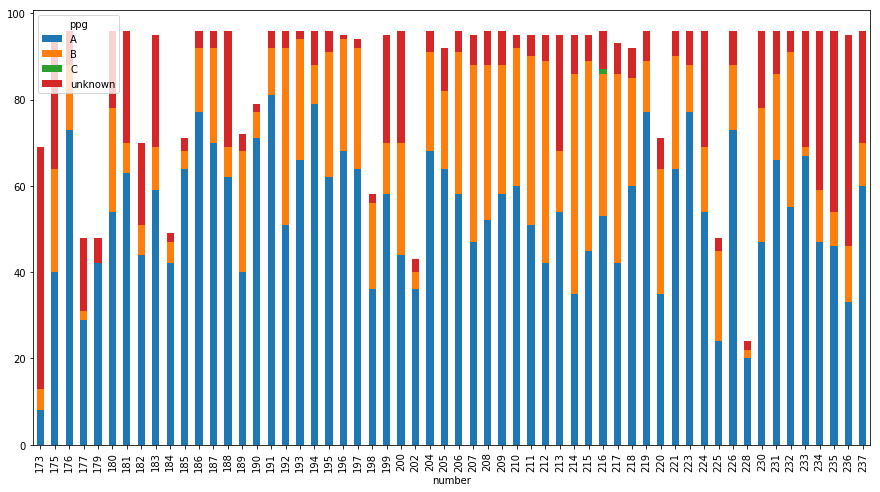

In [33]:
fig, ax = plt.subplots(1, 1)

# distribution of batches vs panel
df2.groupby(['number', 'ppg'])['ppg'].count().unstack().plot.bar(
    stacked=True, 
    figsize=(15,8),
    ax=ax,
)

# identical batches vs panel plot
#pd.crosstab(index=df2['number'], columns=df2['batch_cats'], values=df2['number'], aggfunc='count').plot.bar(
#        stacked=True,
#        figsize=(15,8)
#    )
#ax.bar_label(ax.containers[0])
ax.set_ylim((0,130))
ax.set_ylabel("N Straws",fontsize=25)
ax.set_xlabel("Panel",fontsize=25)
ax.set_title(f'Paper Grade Composition by Panel (MN170 - MN230)',fontsize=25)
fig.savefig(f"ppg_composition_by_panel.png")

plt.close(fig)